# Modeling I

## Nota: Legit (clase positiva), Phishing (clase negativa)

In [11]:
import pickle
from utils import SEED, k_folds_evaluation
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
import scikitplot.plotters as skplt
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image

%matplotlib inline

A continuación cargamos los 5 pliegues que contienen parte de entrenamiento y validación cada uno.

In [3]:
with open('./rebalanced_data/k_folds_sru.pickle', mode='rb') as f:
    k_folds = pickle.load(f)

Cargamos el conjunto de entrenamiento completo, sin pliegues.

In [4]:
with open('./rebalanced_data/train_set_sru.pickle', mode='rb') as f:
    train_sru = pickle.load(f)

## Decision Tree

In [20]:
dt = DecisionTreeClassifier(random_state=SEED, presort=True)

tuned_parameters = {'criterion': np.array(['entropy', 'gini']),
                    'max_depth': np.array([4,6,8,10,15,20,25,30]),
                    'min_samples_split': np.array([0.025, 0.05, 0.10]),
                    'min_samples_leaf': np.array([0.1]),
                    'min_impurity_decrease': np.array([0.001, 0.002, 0.005, 0.01]) 
                   }

grid = GridSearchCV(dt, 
                    param_grid=tuned_parameters, 
                    cv=k_folds[len(k_folds)-1], # En la última posición de k_folds está el objeto de los k-pliegues
                    n_jobs=-1,
                    scoring='precision'
                   ) 

dt_fit = grid.fit(train_sru['x'].multiply(-1), train_sru['y'])

In [21]:
dt_fit.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 0.10000000000000001,
 'min_samples_split': 0.025000000000000001}

In [22]:
dt_final = DecisionTreeClassifier(
            random_state=SEED, 
            presort=True,
            criterion=dt_fit.best_params_['criterion'],
            max_depth=dt_fit.best_params_['max_depth'],
            min_impurity_decrease=dt_fit.best_params_['min_impurity_decrease'],
            min_samples_leaf=dt_fit.best_params_['min_samples_leaf'],
            min_samples_split=dt_fit.best_params_['min_samples_split']
           ).fit(train_sru['x'].multiply(-1), train_sru['y'])

In [8]:
with open('./final_models/dt_final.pickle', mode='wb') as f:
    pickle.dump(dt_final, f, protocol=4)

In [23]:
dt_validation_results = cross_validate(
                           dt_final, 
                           train_sru['x'],
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                        )

In [24]:
k_folds_evaluation(dt_validation_results)

Accuracies: 
[ 0.90025253  0.87689394  0.88573232  0.86788875  0.87737042]
Mean accuracy: 
0.882 (+/- 0.011)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.90174129  0.88        0.88956681  0.87217125  0.88068881]
Mean F1: 
0.885 (+/- 0.010)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.88848039  0.85834334  0.86068477  0.84478673  0.85748503]
Mean precision: 
0.862 (+/- 0.014)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.91540404  0.90277778  0.92045455  0.90139064  0.90518331]
Mean recall: 
0.909 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Visualización del árbol de decisión. (Código base: http://www.techtrek.io/machine-learning-part-2-visualizing-a-decision-tree/)

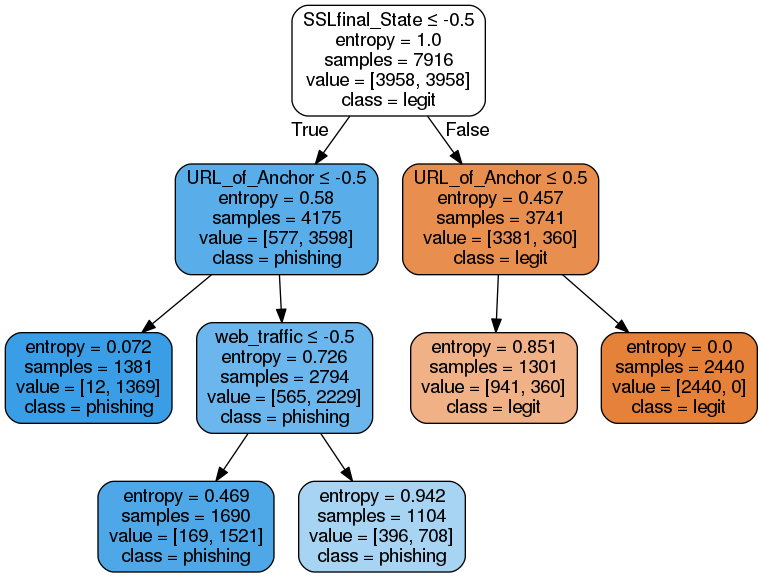

In [25]:
# sudo apt-get install graphviz

dot_data = StringIO()
export_graphviz(dt_final, out_file=dot_data,
                feature_names=train_sru['x'].columns,
                class_names=['legit', 'phishing'],
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

A continuación observamos las cinco variables más importantes en este modelo.

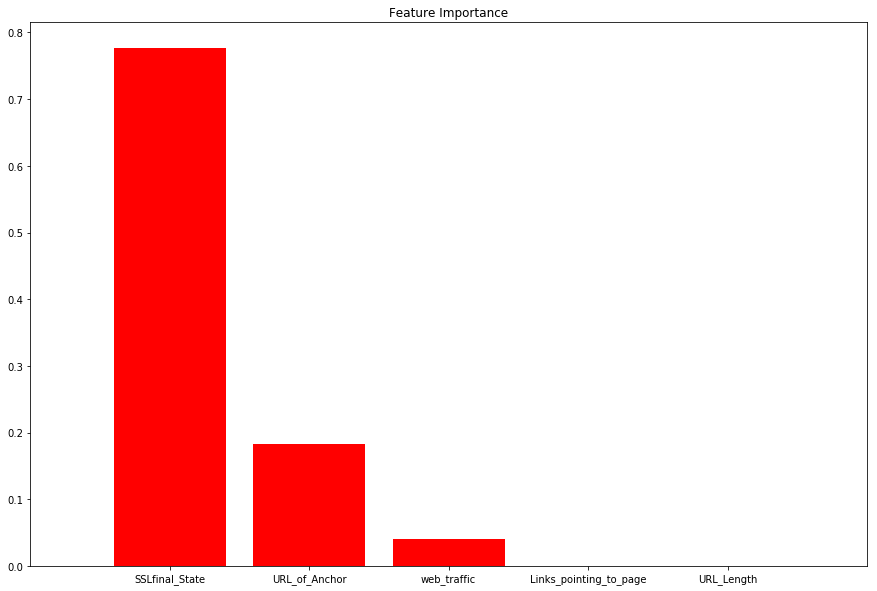

In [102]:
skplt.plot_feature_importances(dt_final, feature_names=train_sru['x'].columns, max_num_features=5, figsize=(15,10))
plt.show()

## Random Forest

Ejecutamos o bien cargamos el RF entrenado de una ejecución anterior.

In [15]:
with open('./gs_models/rf_fit.pickle', mode='rb') as f:
    rf_fit = pickle.load(f)

In [127]:
tuned_parameters = {'n_estimators': np.array([50, 100, 200]),
                    'criterion': ['gini', 'entropy'],
                    'max_features': np.array(['auto']),
                    'max_depth': np.array([4, 8, 10, 15]),
                    'min_samples_split': np.array([0.025, 0.05, 0.10]),
                    'min_samples_leaf': np.array([0.02, 0.05, 0.1]),
                    'min_impurity_decrease': np.array([0.001, 0.002, 0.005, 0.01])
                   }

rf = RandomForestClassifier(random_state=SEED)

grid = GridSearchCV(rf, 
                    param_grid=tuned_parameters, 
                    cv=k_folds[len(k_folds)-1], 
                    n_jobs=-1,
                    scoring='precision') 

rf_fit = grid.fit(train_sru['x'], train_sru['y'])

Se guarda el objeto rf_fit en disco dado que su ejecución ha sido costosa.

In [128]:
with open('./gs_models/rf_fit.pickle', mode='wb') as f:
    pickle.dump(rf_fit, f, protocol=4)

In [129]:
rf_fit.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 0.02,
 'min_samples_split': 0.050000000000000003,
 'n_estimators': 50}

In [16]:
rf_final = RandomForestClassifier(
            random_state=SEED,
            criterion=rf_fit.best_params_['criterion'],
            max_depth=rf_fit.best_params_['max_depth'],
            max_features=rf_fit.best_params_['max_features'],
            min_impurity_decrease=rf_fit.best_params_['min_impurity_decrease'],
            min_samples_leaf=rf_fit.best_params_['min_samples_leaf'],
            min_samples_split=rf_fit.best_params_['min_samples_split'],
            n_estimators=rf_fit.best_params_['n_estimators']).fit(train_sru['x'], train_sru['y'])

In [17]:
with open('./final_models/rf_final.pickle', mode='wb') as f:
    pickle.dump(rf_final, f, protocol=4)

In [13]:
rf_validation_results = cross_validate(
                          RandomForestClassifier(
                            random_state=SEED,
                            criterion=rf_fit.best_params_['criterion'],
                            max_depth=rf_fit.best_params_['max_depth'],
                            max_features=rf_fit.best_params_['max_features'],
                            min_impurity_decrease=rf_fit.best_params_['min_impurity_decrease'],
                            min_samples_leaf=rf_fit.best_params_['min_samples_leaf'],
                            min_samples_split=rf_fit.best_params_['min_samples_split'],
                            n_estimators=rf_fit.best_params_['n_estimators']), 
                           train_sru['x'],
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                        )

In [14]:
k_folds_evaluation(rf_validation_results)

Accuracies: 
[ 0.93813131  0.92234848  0.93371212  0.9102402   0.91340076]
Mean accuracy: 
0.924 (+/- 0.011)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.93851945  0.92402718  0.93466086  0.91169154  0.9150651 ]
Mean F1: 
0.925 (+/- 0.011)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.93266833  0.904474    0.92147239  0.89718482  0.89781022]
Mean precision: 
0.911 (+/- 0.014)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.94444444  0.94444444  0.94823232  0.92667509  0.93299621]
Mean recall: 
0.939 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


A continuación observamos las cinco variables más importantes en este modelo.

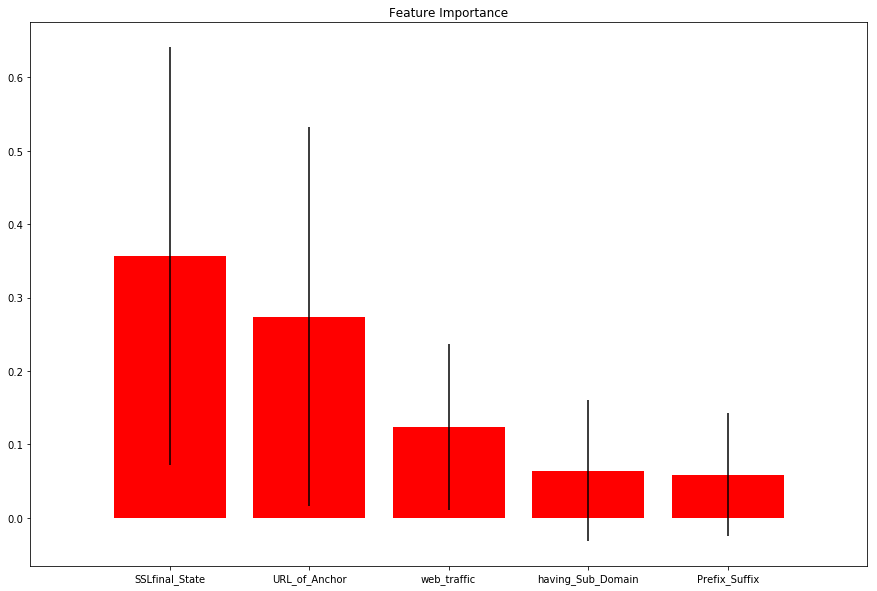

In [135]:
skplt.plot_feature_importances(rf_final, feature_names=train_sru['x'].columns, max_num_features=5, figsize=(15,10))
plt.show()

## Naïve Bayes

### Bernoulli Naïve Bayes

In [57]:
x_nb = train_sru['x'].add(1)
y_nb = np.array([1 if x==1 else 0 for x in list(train_sru['y'])])

tuned_parameters = {'alpha': np.linspace(0, 1, 20)
                   }

bnb = BernoulliNB(fit_prior=True)

grid = GridSearchCV(bnb, 
                    param_grid=tuned_parameters, 
                    cv=k_folds[len(k_folds)-1], 
                    n_jobs=-1,
                    scoring='precision') 

bnb_fit = grid.fit(x_nb, y_nb)

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting 

In [58]:
bnb_fit.best_params_

{'alpha': 0.0}

In [59]:
bnb_final = BernoulliNB(
               alpha=bnb_fit.best_params_['alpha'],
               fit_prior=True
            ).fit(x_nb, y_nb)

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [60]:
with open('./final_models/bnb_final.pickle', mode='wb') as f:
    pickle.dump(bnb_final, f, protocol=4)

In [150]:
bnb_validation_results = cross_validate(
                           bnb_final, 
                           x_nb,
                           y_nb, 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [151]:
k_folds_evaluation(bnb_validation_results)

Accuracies: 
[ 0.91729798  0.90025253  0.90719697  0.89570164  0.89633375]
Mean accuracy: 
0.903356574596
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.91948371  0.90377588  0.90783699  0.89858636  0.8993865 ]
Mean F1: 
0.905813888868
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.89580838  0.87294118  0.90161893  0.87440191  0.87365912]
Mean precision: 
0.883685904119
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.94444444  0.93686869  0.91414141  0.92414665  0.92667509]
Mean recall: 
0.929255258016
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Curva ROC

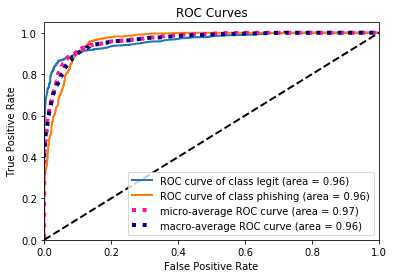

In [171]:
results_to_vals = np.vectorize(lambda x: 'phishing' if x == 1 else 'legit')

skplt.plot_roc_curve(results_to_vals(y_nb), bnb_fit.predict_proba(x_nb))
plt.show()

Curva Precision-Recall

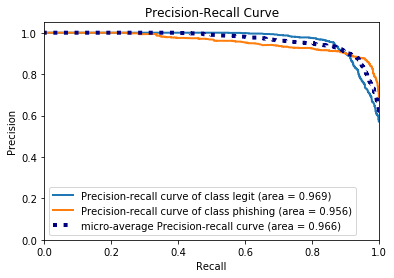

In [170]:
skplt.plot_precision_recall_curve(results_to_vals(y_nb), bnb_fit.predict_proba(x_nb))
plt.show()

### Multinomial Naïve Bayes

In [61]:
tuned_parameters = {'alpha': np.linspace(0, 1, 20) # Pag. 20 http://classes.engr.oregonstate.edu/eecs/winter2011/cs434/notes/bayes-6.pdf
                   }

mnb = MultinomialNB(fit_prior=True)

grid = GridSearchCV(mnb, 
                    param_grid=tuned_parameters, 
                    cv=k_folds[len(k_folds)-1], 
                    n_jobs=-1,
                    scoring='precision') 

mnb_fit = grid.fit(x_nb, y_nb)

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting 

In [62]:
mnb_fit.best_params_

{'alpha': 0.0}

In [63]:
mnb_final = MultinomialNB(
             alpha=mnb_fit.best_params_['alpha'],
             fit_prior=True
            ).fit(x_nb, y_nb)

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [64]:
with open('./final_models/mnb_final.pickle', mode='wb') as f:
    pickle.dump(mnb_final, f, protocol=4)

In [136]:
mnb_validation_results = cross_validate(
                           mnb_final, 
                           x_nb,
                           y_nb, 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [137]:
k_folds_evaluation(mnb_validation_results)

Accuracies: 
[ 0.875       0.84090909  0.84974747  0.84702908  0.84766119]
Mean accuracy: 
0.852069366229
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.87701863  0.84520885  0.84993695  0.85225885  0.85223789]
Mean F1: 
0.855332234034
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.86308068  0.82296651  0.8488665   0.82408501  0.82738095]
Mean precision: 
0.83727592976
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.89141414  0.86868687  0.8510101   0.88242731  0.87863464]
Mean recall: 
0.874434611603
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## XGBoost

In [143]:
tuned_parameters = {'n_estimators': np.array([10, 50, 70, 80, 90, 100]),
                    'max_depth': np.array([4, 8, 15]),
                    'learning_rate': np.array([0.1, 0.2, 0.5]),
                    'gamma': np.array([0.002, 0.005, 0.01]),
                    'max_delta_step': np.array([0, 0.001, 0.002]),
                    'colsample_bytree': np.array([5/len(train_sru['x'].columns), 
                                                  8/len(train_sru['x'].columns), 
                                                  10/len(train_sru['x'].columns)
                                                 ]), 
                    'colsample_bylevel': np.array([1, 0.5, 0.2]),
                    'reg_lambda': np.array([1, 0.5, 0])
                   }

gb = xgb.XGBClassifier(seed=SEED)

grid = GridSearchCV(gb, 
                    param_grid=tuned_parameters, 
                    cv=k_folds[len(k_folds)-1], 
                    n_jobs=-1,
                    scoring='precision') 

gb_fit = grid.fit(train_sru['x'], train_sru['y'])

In [144]:
gb_fit.best_params_

{'colsample_bylevel': 1.0,
 'colsample_bytree': 0.34482758620689657,
 'gamma': 0.002,
 'learning_rate': 0.5,
 'max_delta_step': 0.0,
 'max_depth': 8,
 'n_estimators': 80,
 'reg_lambda': 0.5}

In [145]:
gb_final = xgb.XGBClassifier(seed=SEED,
             n_estimators=gb_fit.best_params_['n_estimators'],
             max_depth=gb_fit.best_params_['max_depth'],
             learning_rate=gb_fit.best_params_['learning_rate'],
             gamma=gb_fit.best_params_['gamma'],
             max_delta_step=gb_fit.best_params_['max_delta_step'],
             colsample_bytree=gb_fit.best_params_['colsample_bytree'],
             colsample_bylevel=gb_fit.best_params_['colsample_bylevel'],
             reg_lambda=gb_fit.best_params_['reg_lambda']
            ).fit(train_sru['x'], train_sru['y'])

In [20]:
with open('./final_models/xgboost_final.pickle', mode='wb') as f:
    pickle.dump(gb_final, f, protocol=4)

In [147]:
gb_validation_results = cross_validate(
                           gb_final,
                           train_sru['x'],
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                         )

In [148]:
k_folds_evaluation(gb_validation_results)

Accuracies: 
[ 0.97537879  0.97159091  0.9760101   0.97029077  0.97029077]
Mean accuracy: 
0.973 (+/- 0.002)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.97533207  0.971537    0.97604035  0.96996805  0.970347  ]
Mean F1: 
0.973 (+/- 0.003)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.97718631  0.97338403  0.97481108  0.98062016  0.96851385]
Mean precision: 
0.975 (+/- 0.004)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.97348485  0.96969697  0.97727273  0.95954488  0.9721871 ]
Mean recall: 
0.970 (+/- 0.006)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Extra Trees Classifier

In [137]:
xt = ExtraTreesClassifier(
            random_state=SEED,
            max_depth=rf_fit.best_params_['max_depth'],
            max_features=rf_fit.best_params_['max_features'],
            min_impurity_decrease=rf_fit.best_params_['min_impurity_decrease'],
            min_samples_leaf=rf_fit.best_params_['min_samples_leaf'],
            min_samples_split=rf_fit.best_params_['min_samples_split'],
            n_estimators=rf_fit.best_params_['n_estimators']
         )

xt_fit = xt.fit(train_sru['x'], train_sru['y'])

xt_validation_results = cross_validate(
                           xt_fit,
                           train_sru['x'],
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                         )

In [138]:
xt_final = ExtraTreesClassifier(
                random_state=SEED,
                max_depth=rf_fit.best_params_['max_depth'],
                max_features=rf_fit.best_params_['max_features'],
                min_impurity_decrease=rf_fit.best_params_['min_impurity_decrease'],
                min_samples_leaf=rf_fit.best_params_['min_samples_leaf'],
                min_samples_split=rf_fit.best_params_['min_samples_split'],
                n_estimators=rf_fit.best_params_['n_estimators']
            ).fit(train_sru['x'], train_sru['y'])

In [139]:
with open('./final_models/xt_final.pickle', mode='wb') as f:
    pickle.dump(xt_final, f, protocol=4)

In [140]:
k_folds_evaluation(xt_validation_results)

Accuracies: 
[ 0.92866162  0.91287879  0.93055556  0.90644753  0.9159292 ]
Mean accuracy: 
0.919 (+/- 0.009)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.92879647  0.91502463  0.93107769  0.9079602   0.91744258]
Mean F1: 
0.920 (+/- 0.009)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.92704403  0.89302885  0.92412935  0.89351285  0.90121951]
Mean precision: 
0.908 (+/- 0.015)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.93055556  0.93813131  0.93813131  0.92288243  0.93426043]
Mean recall: 
0.933 (+/- 0.006)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


A continuación observamos las cinco variables más importantes en este modelo.

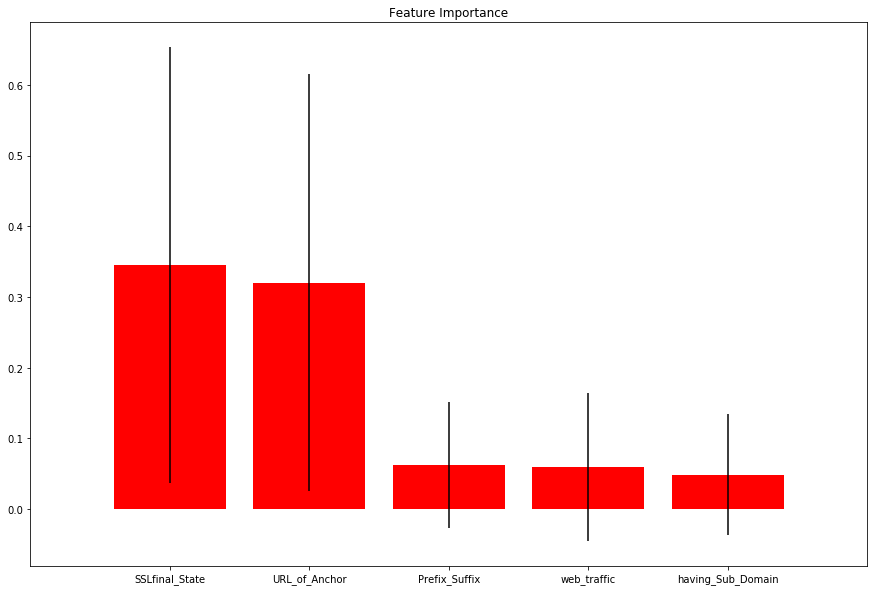

In [142]:
skplt.plot_feature_importances(xt_final, feature_names=train_sru['x'].columns, max_num_features=5, figsize=(15,10))
plt.show()

## SVM

### Kernel Lineal 

In [69]:
tuned_parameters = {'C': np.array([70, 80, 90, 100]),                    
                    'loss':np.array(['hinge', 'squared_hinge']),
                    'max_iter': np.array([5000])
                   }

l_svm = LinearSVC(random_state=SEED, penalty='l2', dual=True)

grid = GridSearchCV(l_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds[len(k_folds)-1], 
                    n_jobs=-1,
                    scoring='precision') 

l_svm_fit = grid.fit(train_sru['x'], train_sru['y'])

In [43]:
with open('./gs_models/lineal_svm_fit.pickle', mode='wb') as f:
    pickle.dump(l_svm_fit, f, protocol=4)

In [70]:
l_svm_fit.best_params_

{'C': 70, 'loss': 'squared_hinge', 'max_iter': 5000}

In [22]:
lsvm_final = LinearSVC(
                 C=l_svm_fit.best_params_['C'],
                 loss=l_svm_fit.best_params_['loss'],
                 max_iter=l_svm_fit.best_params_['max_iter'],
                 penalty='l2',
                 dual=True
             ).fit(train_sru['x'], train_sru['y'])

In [23]:
with open('./final_models/lsvm_final.pickle', mode='wb') as f:
    pickle.dump(lsvm_final, f, protocol=4)

In [44]:
lsvm_validation_results = cross_validate(
                           lsvm_final,                            
                           train_sru['x'],
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                         )

In [45]:
k_folds_evaluation(lsvm_validation_results)

Accuracies: 
[ 0.92992424  0.91477273  0.92992424  0.91213654  0.91719343]
Mean accuracy: 
0.921 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.92852543  0.9156777   0.93066833  0.9125236   0.91928527]
Mean F1: 
0.921 (+/- 0.007)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.94743758  0.90605686  0.92088999  0.9085213   0.89663462]
Mean precision: 
0.916 (+/- 0.018)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.91035354  0.92550505  0.94065657  0.91656131  0.94310999]
Mean recall: 
0.927 (+/- 0.013)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Kernel Polinomial

In [ ]:
tuned_parameters = {'degree': np.array([2, 3, 5, 10]), 
                    'C': np.array([0.1, 1, 10, 11 ,100]),
                    'coef0': np.array([0, 10, 99, 100, 101]),
                    'gamma': np.array([0, 10, 99, 100, 101]),
                    'max_iter': np.array([5000])
                   }

poly_svm = SVC(kernel='poly', random_state=SEED, cache_size=2048)

grid = GridSearchCV(poly_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds[len(k_folds)-1], 
                    n_jobs=-1,
                    scoring='precision') 

poly_svm_fit = grid.fit(train_sru['x'], train_sru['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

Se guarda el objeto del modelo, porque su ejecución ha sido costosa. De hecho, ha habido que limitar el número de iteraciones dado que en 8 horas la ejecución del GridSearch no había acabado.

In [75]:
with open('./gs_models/poly_svm_fit.pickle', mode='wb') as f:
    pickle.dump(poly_svm_fit, f, protocol=4)

In [74]:
poly_svm_fit.best_params_

{'C': 9.0, 'coef0': 0, 'degree': 3, 'gamma': 10, 'max_iter': 5000}

In [76]:
poly_svm_final = SVC(
                     degree=poly_svm_fit.best_params_['degree'],
                     C=poly_svm_fit.best_params_['C'],
                     coef0=poly_svm_fit.best_params_['coef0'],
                     gamma=poly_svm_fit.best_params_['gamma'],
                     max_iter=poly_svm_fit.best_params_['max_iter'],
                     kernel='poly', 
                     random_state=SEED, 
                     cache_size=2048
                 ).fit(train_sru['x'], train_sru['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [77]:
with open('./final_models/poly_svm_final.pickle', mode='wb') as f:
    pickle.dump(poly_svm_final, f, protocol=4)

In [78]:
poly_validation_results = cross_validate(
                           poly_svm_final,                            
                           train_sru['x'],
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

In [79]:
k_folds_evaluation(poly_validation_results)

Accuracies: 
[ 0.95328283  0.93876263  0.94823232  0.95006321  0.95259166]
Mean accuracy: 
0.949 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.95304569  0.93933709  0.9482976   0.94939142  0.95268139]
Mean F1: 
0.949 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.95790816  0.93060719  0.94710327  0.96233766  0.95088161]
Mean precision: 
0.950 (+/- 0.011)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.94823232  0.94823232  0.94949495  0.93678887  0.95448799]
Mean recall: 
0.947 (+/- 0.006)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Kernel RBF

In [29]:
tuned_parameters = { 
                    'C': np.array([0.1, 0.5, 10, 100]),
                    'gamma': np.array([0.1, 10, 100]),
                    'max_iter': np.array([5000])
                   }

rbf_svm = SVC(kernel='rbf', random_state=SEED, cache_size=2048)

grid = GridSearchCV(rbf_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds[len(k_folds)-1], 
                    n_jobs=-1,
                    scoring='precision') 

rbf_svm_fit = grid.fit(train_sru['x'], train_sru['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

In [32]:
with open('./gs_models/rbf_svm_fit.pickle', mode='wb') as f:
    pickle.dump(rbf_svm_fit, f, protocol=4)

In [81]:
rbf_svm_fit.best_params_

{'C': 0.10000000000000001, 'gamma': 10.0, 'max_iter': 5000}

In [83]:
rbf_svm_final = SVC(
                 C=rbf_svm_fit.best_params_['C'],
                 gamma=rbf_svm_fit.best_params_['gamma'],
                 max_iter=rbf_svm_fit.best_params_['max_iter'],
                 kernel='rbf', 
                 random_state=SEED, 
                 cache_size=2048
               ).fit(train_sru['x'], train_sru['y'])

In [84]:
with open('./final_models/rbf_svm_final.pickle', mode='wb') as f:
    pickle.dump(rbf_svm_final, f, protocol=4)

In [85]:
rbf_validation_results = cross_validate(
                           rbf_svm_final,                            
                           train_sru['x'],
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                         )

In [86]:
k_folds_evaluation(rbf_validation_results)

Accuracies: 
[ 0.58775253  0.59785354  0.58838384  0.5954488   0.65297092]
Mean accuracy: 
0.604 (+/- 0.025)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.30010718  0.32734952  0.3034188   0.3220339   0.47160731]
Mean F1: 
0.345 (+/- 0.064)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.9929078   1.          0.98611111  0.99346405  0.98790323]
Mean precision: 
0.992 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.17676768  0.19570707  0.17929293  0.19216182  0.30973451]
Mean recall: 
0.211 (+/- 0.050)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Kernel Sigmoidal

In [119]:
tuned_parameters = { 
                    'C': np.array([0.1, 0.5, 5, 10, 100]),
                    'gamma': np.array([0.01, 0.1, 10, 100]),
                    'max_iter': np.array([5000])
                   }

sig_svm = SVC(kernel='sigmoid', random_state=SEED, cache_size=2048)

grid = GridSearchCV(sig_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds[len(k_folds)-1], 
                    n_jobs=-1,
                    scoring='precision') 

sig_svm_fit = grid.fit(train_sru['x'], train_sru['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

In [120]:
with open('./gs_models/sig_svm_fit.pickle', mode='wb') as f:
    pickle.dump(sig_svm_fit, f, protocol=4)

In [121]:
sig_svm_fit.best_params_

{'C': 5.0, 'gamma': 0.01, 'max_iter': 5000}

In [122]:
sig_svm_final = SVC(
                 C=sig_svm_fit.best_params_['C'],
                 gamma=sig_svm_fit.best_params_['gamma'],
                 max_iter=sig_svm_fit.best_params_['max_iter'],
                 kernel='sigmoid', 
                 random_state=SEED, 
                 cache_size=2048
               ).fit(train_sru['x'], train_sru['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [123]:
with open('./final_models/sig_svm_final.pickle', mode='wb') as f:
    pickle.dump(sig_svm_final, f, protocol=4)

In [124]:
sig_validation_results = cross_validate(
                           sig_svm_final,                            
                           train_sru['x'],
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds[len(k_folds)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [125]:
k_folds_evaluation(sig_validation_results)

Accuracies: 
[ 0.93181818  0.91287879  0.92929293  0.90960809  0.91908976]
Mean accuracy: 
0.921 (+/- 0.009)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.93258427  0.91523342  0.92991239  0.91090343  0.92049689]
Mean F1: 
0.922 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.92222222  0.89114833  0.92183623  0.8980344   0.9047619 ]
Mean precision: 
0.908 (+/- 0.013)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.94318182  0.94065657  0.93813131  0.92414665  0.93678887]
Mean recall: 
0.937 (+/- 0.007)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
